In [ ]:
!pip install -q transformers datasets torch accelerate

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import torch


In [ ]:
dataset = load_dataset("imdb")
train_data = dataset["train"].shuffle(seed=42).select(range(2000))   # smaller subset for speed
test_data  = dataset["test"].shuffle(seed=42).select(range(1000))



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=128)

train_enc = train_data.map(tokenize, batched=True, batch_size=512)
test_enc  = test_data.map(tokenize,  batched=True, batch_size=512)

train_enc.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_enc.set_format(type="torch",  columns=["input_ids", "attention_mask", "label"])


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
)

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_enc,
    eval_dataset=test_enc
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.446461
2,0.363677,0.533841


TrainOutput(global_step=500, training_loss=0.36367694091796876, metrics={'train_runtime': 106.95, 'train_samples_per_second': 37.401, 'train_steps_per_second': 4.675, 'total_flos': 263111055360000.0, 'train_loss': 0.36367694091796876, 'epoch': 2.0})

In [ ]:
metrics = trainer.evaluate()
print(f"\n✅ Test Loss: {metrics['eval_loss']:.4f}")


✅ Test Loss: 0.5338


In [ ]:
def predict_sentiment(text):
    # Get the same device as the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Tokenize input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}  # move inputs to GPU if available

    # Run prediction
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        label = torch.argmax(probs).item()

    return "Positive" if label == 1 else "Negative"


In [ ]:
print(predict_sentiment("The movie was fantastic and full of life!"))
print(predict_sentiment("That was the most boring film I’ve ever seen."))

Positive
Negative


In [ ]:
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 0.5338412523269653, 'eval_runtime': 6.9861, 'eval_samples_per_second': 143.14, 'eval_steps_per_second': 17.893, 'epoch': 2.0}


Test Accuracy: 84.30%


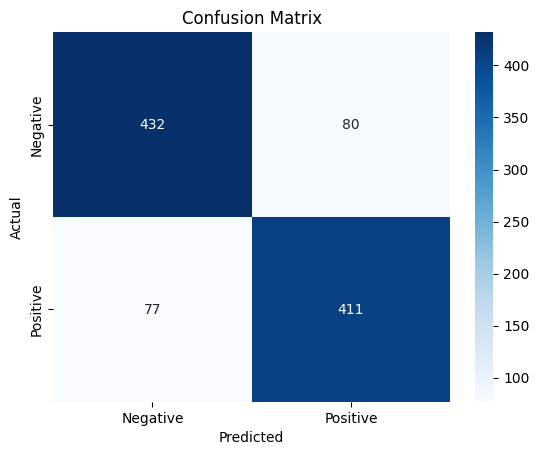

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

preds = trainer.predict(test_enc)
y_true = np.array(test_enc["label"])
y_pred = np.argmax(preds.predictions, axis=1)

acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {acc*100:.2f}%")

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
